In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import xarray as xr
import glob
import datetime as dt
import tqdm
from sklearn.cluster import KMeans as kmeans
import joblib
import cartopy.crs as ccrs

In [2]:
def load_scws(rid):
    df1 = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/points/"+rid+"_scw_envs_df.csv")
    
    df1["cluster_new"] = df1.cluster.map({0:2,2:1,1:0})
    df1 = df1.set_index(pd.DatetimeIndex(df1.dt_utc))
    
    return df1

def remove_suspect_gusts(df):
    #Including the removal of Kurnell tornado
    dts = ["2010-12-14 07:03:00","2011-01-11 03:49:00","2015-12-15 23:33:00","2020-02-09 01:00:00","2020-02-09 03:18:00","2020-05-25 06:11:00",
          "2012-11-02 18:58:00","2012-12-20 21:19:00","2012-12-15 13:00:00","2012-12-29 16:15:00","2012-12-30 06:25:00","2012-12-30 18:01:00","2013-01-02 08:15:00",
          "2013-01-05 03:36:00","2013-01-12 15:22:00","2013-02-11 07:56:00"]
    return df[np.in1d(df.dt_utc,dts,invert=True)]

In [3]:
rids = ["2","66","69","70","71","64","8","72","75","19","73","78","49","4","40","48","68","63","76","77"]
scws = [load_scws(rid) for rid in rids]
df_scw = remove_suspect_gusts(pd.concat(scws,axis=0))

In [4]:
def load_cluster():

    #Load the k-means clustering model 

    cluster_mod = joblib.load('/g/data/w40/ab4502/figs/ExtremeWind/case_studies/cluster_model_era5.pkl')
    cluster_input = pd.read_csv("/g/data/w40/ab4502/figs/ExtremeWind/case_studies/cluster_input_era5.csv").drop(columns=["Unnamed: 0"])

    return cluster_mod, cluster_input

def transform_era5(f, cluster_mod, cluster_input):

    #Transform the ERA5 diagnostics for input into the k-means model

    s06 = (f["s06"] - cluster_input["s06"].min()) / (cluster_input["s06"].max()-cluster_input["s06"].min())
    qmean01 = (f["qmean01"] - cluster_input["qmean01"].min()) / (cluster_input["qmean01"].max()-cluster_input["qmean01"].min())
    lr13 = (f["lr13"] - cluster_input["lr13"].min()) / (cluster_input["lr13"].max()-cluster_input["lr13"].min())
    Umean06 = (f["Umean06"] - cluster_input["Umean06"].min()) / (cluster_input["Umean06"].max()-cluster_input["Umean06"].min())

    return s06, qmean01, lr13, Umean06

def era5_clustering(s06, qmean01, lr13, Umean06, f, cluster_mod):

    #Use the k-means clustering model on all the spatial ERA5 data. This will assign a cluster to every grid point.

    dim=("time","lat","lon")

    s06_1d = s06.stack(dim=dim)
    qmean01_1d = qmean01.stack(dim=dim)
    lr13_1d = lr13.stack(dim=dim)
    Umean06_1d = Umean06.stack(dim=dim)
    X = pd.DataFrame({"s06":s06_1d, "qmean01":qmean01_1d, "lr13":lr13_1d, "Umean06":Umean06_1d})
    preds = cluster_mod.predict(X).reshape(s06.shape)
    preds_new = np.copy(preds)
    preds_new[preds==0]=2
    preds_new[preds==1]=0
    preds_new[preds==2]=1

    era5_cluster = xr.Dataset({"cluster":(dim, preds_new), "bdsd":(dim, f.bdsd.values)},\
            coords={"lat":(("lat"), f.lat.values), "lon":(("lon"), f.lon.values), "time":(("time"), f.time.values)}).chunk({"time":"auto"})

    return era5_cluster

def latlon_dist(lat, lon, lats, lons):

        #Calculate great circle distance (Harversine) between a lat lon point (lat, lon) and a list of lat lon
        # points (lats, lons)

        R = 6373.0

        lat1 = np.deg2rad(lat)
        lon1 = np.deg2rad(lon)
        lat2 = np.deg2rad(lats)
        lon2 = np.deg2rad(lons)
                
        dlon = lon2 - lon1
        dlat = lat2 - lat1

        a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

        return (R * c)

def get_point_data(fname,time,lat,lon,r,var):
    
    f = xr.open_dataset(glob.glob(fname)[0])[var].sel({"time":time.replace(minute=0)})
    
    lats = f.coords.get("lat").values
    lons = f.coords.get("lon").values
    x,y = np.meshgrid(lons,lats)
    dist_km = (latlon_dist(lat, lon, y, x) )
    a,b = np.where( (dist_km <= r) )
    target_lons = xr.DataArray(lons[b],dims="points")
    target_lats = xr.DataArray(lats[a],dims="points")    
    f_slice = (f.sel(lon=target_lons, lat=target_lats))
    
    #Return the value of the point with the highest absolute value
    return pd.DataFrame([f_slice[v].values[np.abs(f_slice[v]).argmax()] for v in var], index=var)

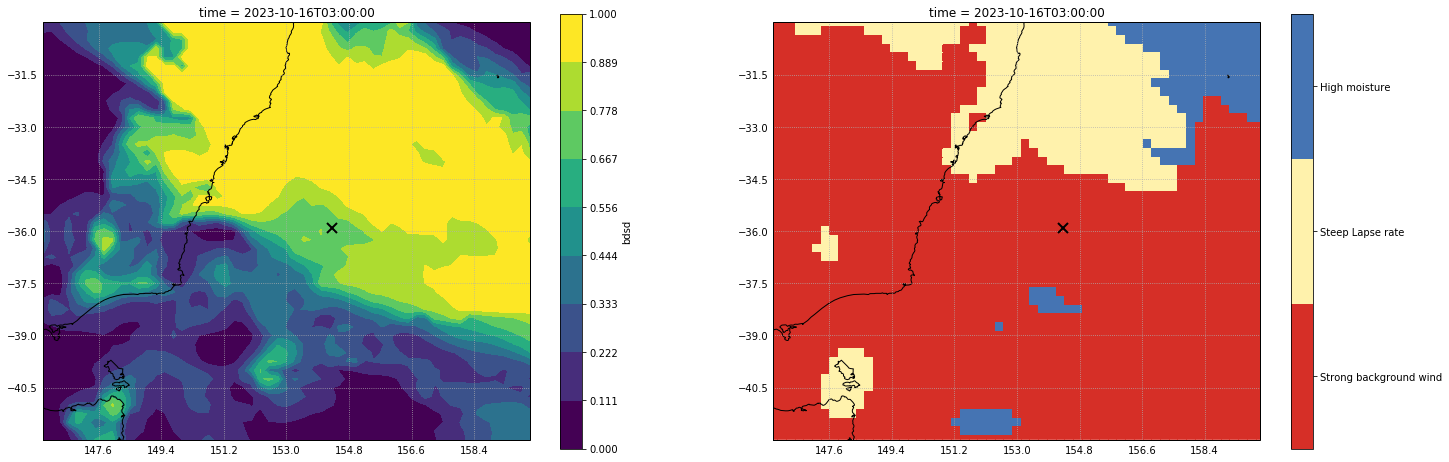

In [5]:
ship_lat = -35.9070
ship_lon = 154.3239
event_time = dt.datetime(2023,10,16,3,35)

f = xr.open_dataset("/g/data/w40/ab4502/IN2023_V06/data/era5/era5_20231015_20231016.nc")
cluster_mod, cluster_input = load_cluster()
s06, qmean01, lr13, Umean06 = transform_era5(f, cluster_mod, cluster_input)
era5_cluster = era5_clustering(s06, qmean01, lr13, Umean06, f, cluster_mod)

plt.figure(figsize=[24,8])
ax=plt.subplot(1,2,1,projection=ccrs.PlateCarree())
xr.plot.contourf(era5_cluster.sel(time=event_time.replace(minute=0)).bdsd,ax=ax,levels=np.linspace(0,1,10))
ax.set_xlim([146,160])
ax.set_ylim([-42,-30])
ax.coastlines("10m")
g=ax.gridlines(linestyle=":",draw_labels=True); g.xlabels_top=False; g.ylabels_right=False
ax.plot(ship_lon,ship_lat,marker="x",color="k",mew=2,ms=10)

ax=plt.subplot(1,2,2,projection=ccrs.PlateCarree())
c=xr.plot.pcolormesh(era5_cluster.sel(time=event_time.replace(minute=0)).cluster,ax=ax,levels=[-0.5,0.5,1.5,2.5],add_colorbar=False,colors=[plt.get_cmap("RdYlBu")(i) for i in [0.1,0.46,0.9]])
cb=plt.colorbar(c)
cb.set_ticks([0,1,2])
cb.set_ticklabels(["Strong background wind","Steep Lapse rate","High moisture"])
ax.set_xlim([146,160])
ax.set_ylim([-42,-30])
ax.coastlines("10m")
g=ax.gridlines(linestyle=":",draw_labels=True); g.xlabels_top=False; g.ylabels_right=False
ax.plot(ship_lon,ship_lat,marker="x",color="k",mew=2,ms=10)

In [6]:
var=["s06","qmean01","lr13","Umean06"]
fname = "/g/data/w40/ab4502/IN2023_V06/data/era5/era5_20231015_20231016.nc"
event_stats = get_point_data(fname,event_time,ship_lat,ship_lon,50,var).T
event_stats_norm = event_stats.copy()

In [7]:
event_stats_norm

,s06,qmean01,lr13,Umean06
0,26.492188,8.240234,6.660156,18.414062


In [8]:
event_stats_norm["s06"] = (event_stats["s06"] - cluster_input["s06"].min()) / (cluster_input["s06"].max()-cluster_input["s06"].min())
event_stats_norm["qmean01"] = (event_stats["qmean01"] - cluster_input["qmean01"].min()) / (cluster_input["qmean01"].max()-cluster_input["qmean01"].min())
event_stats_norm["lr13"] = (event_stats["lr13"] - cluster_input["lr13"].min()) / (cluster_input["lr13"].max()-cluster_input["lr13"].min())
event_stats_norm["Umean06"] = (event_stats["Umean06"] - cluster_input["Umean06"].min()) / (cluster_input["Umean06"].max()-cluster_input["Umean06"].min())
print(cluster_mod.predict(event_stats_norm))
print("Cluster 1 in this model is Strong Background Wind")

[1]
Cluster 1 in this model is Strong Background Wind


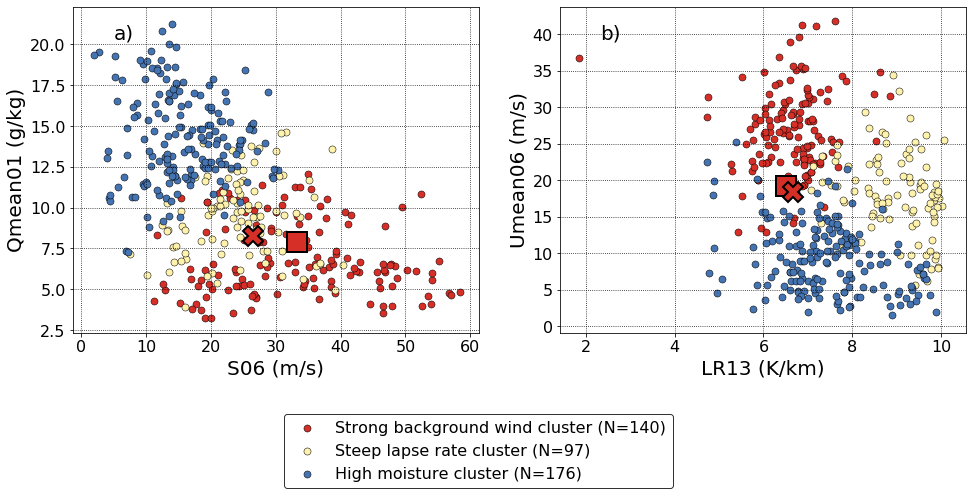

In [9]:
p=[plt.get_cmap("RdYlBu")(i) for i in [0.1,0.46,0.9]]
plt.figure(figsize=[16,6])

plt.subplot(1,2,1)
plt.ylabel("Qmean01")
plt.xlabel("S06")
plt.scatter(df_scw.query("cluster_new==0").s06, df_scw.query("cluster_new==0").qmean01,color=p[0],marker="o",s=50,edgecolor="k",linewidths=0.5,
            label="Strong background wind cluster (N="+str(df_scw.query("cluster_new==0").shape[0])+")")
plt.scatter(df_scw.query("cluster_new==1").s06, df_scw.query("cluster_new==1").qmean01,color=p[1],marker="o",s=50,edgecolor="k",linewidths=0.5,
            label="Steep lapse rate cluster (N="+str(df_scw.query("cluster_new==1").shape[0])+")")
plt.scatter(df_scw.query("cluster_new==2").s06, df_scw.query("cluster_new==2").qmean01,color=p[2],marker="o",s=50,edgecolor="k",linewidths=0.5,
            label="High moisture cluster (N="+str(df_scw.query("cluster_new==2").shape[0])+")")
plt.plot(event_stats["s06"],event_stats["qmean01"],marker="X",color=p[0],ms=20,mec="k",mew=2)
plt.gca().grid(color="k",ls=":")
plt.gca().tick_params("both",labelsize=16)
plt.gca().set_ylabel("Qmean01 (g/kg)",size=20)
plt.gca().set_xlabel("S06 (m/s)",size=20)
plt.gca().text(0.1,0.9,"a)",transform=plt.gca().transAxes,size=20)
l=plt.legend(loc=8,fontsize=16,bbox_to_anchor=(1,-0.5),edgecolor="k")

plt.plot(33.3, 7.9 ,marker="s",color=p[0],ms=20,mec="k",mew=2)

plt.subplot(1,2,2)
plt.ylabel("Umean06")
plt.xlabel("LR13")
plt.scatter(df_scw.query("cluster_new==0").lr13, df_scw.query("cluster_new==0").Umean06,color=p[0],marker="o",s=50,edgecolor="k",linewidths=0.5)
plt.scatter(df_scw.query("cluster_new==1").lr13, df_scw.query("cluster_new==1").Umean06,color=p[1],marker="o",s=50,edgecolor="k",linewidths=0.5)
plt.scatter(df_scw.query("cluster_new==2").lr13, df_scw.query("cluster_new==2").Umean06,color=p[2],marker="o",s=50,edgecolor="k",linewidths=0.5)
plt.plot(6.5, 19.2 ,marker="s",color=p[0],ms=20,mec="k",mew=2)
plt.plot(event_stats["lr13"],event_stats["Umean06"],marker="X",color=p[0],ms=20,mec="k",mew=2)
plt.gca().grid(color="k",ls=":")
plt.gca().tick_params("both",labelsize=16)
plt.gca().set_ylabel("Umean06 (m/s)",size=20)
plt.gca().set_xlabel("LR13 (K/km)",size=20)
plt.gca().text(0.1,0.9,"b)",transform=plt.gca().transAxes,size=20)
plt.savefig("/g/data/w40/ab4502/IN2023_V06/figs/clustering.jpeg",dpi=400,bbox_inches="tight")

In [ ]:
plt.figure(figsize=[24,16])
ax=plt.subplot(2,2,1,projection=ccrs.PlateCarree())
xr.plot.contourf(f.sel(time=event_time.replace(minute=0)).qmean01,ax=ax,cmap=plt.get_cmap("Blues"))
ax.set_xlim([146,160])
ax.set_ylim([-42,-30])
ax.coastlines("10m")
g=ax.gridlines(linestyle=":",draw_labels=True); g.xlabels_top=False; g.ylabels_right=False
ax.plot(ship_lon,ship_lat,marker="x",color="k",mew=2,ms=10)
plt.title("Qmean01")

ax=plt.subplot(2,2,2,projection=ccrs.PlateCarree())
xr.plot.contourf(f.sel(time=event_time.replace(minute=0)).Umean06,ax=ax,cmap=plt.get_cmap("Oranges"))
ax.set_xlim([146,160])
ax.set_ylim([-42,-30])
ax.coastlines("10m")
g=ax.gridlines(linestyle=":",draw_labels=True); g.xlabels_top=False; g.ylabels_right=False
ax.plot(ship_lon,ship_lat,marker="x",color="k",mew=2,ms=10)
plt.title("Umean06")

ax=plt.subplot(2,2,3,projection=ccrs.PlateCarree())
xr.plot.contourf(f.sel(time=event_time.replace(minute=0)).lr13,ax=ax,cmap=plt.get_cmap("Greens"),levels=np.linspace(0,12,7))
ax.set_xlim([146,160])
ax.set_ylim([-42,-30])
ax.coastlines("10m")
g=ax.gridlines(linestyle=":",draw_labels=True); g.xlabels_top=False; g.ylabels_right=False
ax.plot(ship_lon,ship_lat,marker="x",color="k",mew=2,ms=10)
plt.title("lr13")

ax=plt.subplot(2,2,4,projection=ccrs.PlateCarree())
xr.plot.contourf(f.sel(time=event_time.replace(minute=0)).s06,ax=ax,cmap=plt.get_cmap("Reds"))
ax.set_xlim([146,160])
ax.set_ylim([-42,-30])
ax.coastlines("10m")
g=ax.gridlines(linestyle=":",draw_labels=True); g.xlabels_top=False; g.ylabels_right=False
ax.plot(ship_lon,ship_lat,marker="x",color="k",mew=2,ms=10)
plt.title("s06")